Task: Analysis of House Pricing and finding correlations for influencing factors

# Summary
* The highest correlating numerical columns with an correlation coefficient +-0.3 that can be selected are: 'SalePrice', 'GrLivArea', 'GarageCars', 'OverallQual', 'ExterQual', 'YearBuilt', 'TotalBsmtSF', 'HeatingQC', 'KitchenQual' with a adjusted R² of 0.78
* for the categorical values neighborhood the quarers 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_MeadowV', 'Neighborhood_NPkVill', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',  'Neighborhood_StoneBr' have been selected

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 100)

sns.set_style("whitegrid") # set some seaborn styles

In [2]:
housing = pd.read_csv("Source//train.csv", dtype={"SalePrice" : float})

In [3]:
housing.shape

(1460, 81)

In [4]:
housing.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


# 1. cleaning

In [5]:
housing.isnull().sum() / len(housing)

Id               0.000000
MSSubClass       0.000000
MSZoning         0.000000
LotFrontage      0.177397
LotArea          0.000000
Street           0.000000
Alley            0.937671
LotShape         0.000000
LandContour      0.000000
Utilities        0.000000
LotConfig        0.000000
LandSlope        0.000000
Neighborhood     0.000000
Condition1       0.000000
Condition2       0.000000
BldgType         0.000000
HouseStyle       0.000000
OverallQual      0.000000
OverallCond      0.000000
YearBuilt        0.000000
YearRemodAdd     0.000000
RoofStyle        0.000000
RoofMatl         0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
MasVnrType       0.005479
MasVnrArea       0.005479
ExterQual        0.000000
ExterCond        0.000000
Foundation       0.000000
BsmtQual         0.025342
BsmtCond         0.025342
BsmtExposure     0.026027
BsmtFinType1     0.025342
BsmtFinSF1       0.000000
BsmtFinType2     0.026027
BsmtFinSF2       0.000000
BsmtUnfSF        0.000000
TotalBsmtSF 

## 1.1 Ignore Cols with hight NaN values

In [6]:
null_cols = housing.isna().sum()
null_perc = null_cols[null_cols > 0] / len(housing)
to_drop = null_perc[null_perc > .8].index
to_drop

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [7]:
housing = housing.drop(columns=to_drop)

**drop C - commercial use**

In [8]:
housing.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [9]:
index_names_C = housing[housing["MSZoning"] == "C (all)"].index
index_names_C
housing.drop(index_names_C, inplace=True)

## 1.2 Replace "isnan"

In [10]:
housing = housing.replace(['isnan', "nan", "NaN"], np.isnan)

## 1.3 Check for Duplicates

In [11]:
housing.duplicated().sum()

0

## 1.4 Analyse Pricing

In [12]:
housing.SalePrice.describe()

count      1450.000000
mean     181654.942069
std       79176.485241
min       37900.000000
25%      130000.000000
50%      163945.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

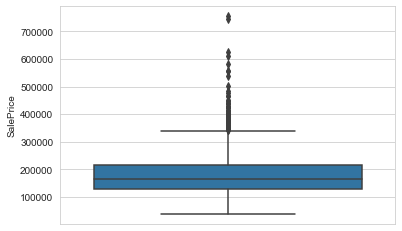

In [13]:
sns.boxplot(data=housing, y="SalePrice")

## 1.5 Relaitve SalePrice
for comparison with categorical data

In [14]:
housing = housing.assign(SalePrice_sqm=housing["SalePrice"]/housing["LotArea"])
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_sqm
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500.0,24.674556
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500.0,18.906250
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500.0,19.866667
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000.0,14.659686
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000.0,17.531557


In [15]:
housing.SalePrice_sqm.describe()

count    1450.000000
mean       21.157727
std        12.379523
min         1.390441
25%        13.871869
50%        17.877013
75%        23.825027
max        95.384615
Name: SalePrice_sqm, dtype: float64

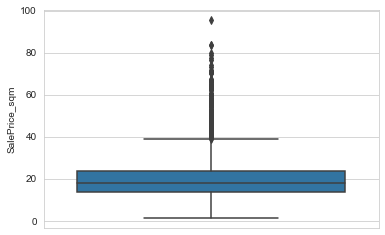

In [16]:
sns.boxplot(data=housing, y="SalePrice_sqm")

## 1.6 interesting Cols (first round)

In [17]:
interst_cols = ["SalePrice", "MSSubClass", "LotArea", "GrLivArea", "GarageCars", "LotFrontage", 
                "OverallQual", "ExterQual", "GarageQual", "BedroomAbvGr",
                "ExterCond", "OverallCond", "YearBuilt", "FireplaceQu", "BsmtFullBath",
               "TotalBsmtSF", "HeatingQC", "CentralAir", "KitchenQual"]

In [18]:
to_dummy = ["MSZoning", "Utilities", "HouseStyle", "Heating",
            "Neighborhood", "Functional", "BsmtExposure"]

# 2 Transform to Nummerical

**Rating**

In [19]:
rating_val = {"Ex" : 5, "Gd" : 4, "TA" : 3, "Fa" : 2, "Po" : 1, "NA" : 0}

In [20]:
to_numerical = ["ExterCond", "ExterQual", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual"]

for col in to_numerical:
    housing[col] = housing[col].replace(rating_val)

In [21]:
housing[to_numerical] = housing[to_numerical].astype(str).astype(float)

**Boolean**

In [22]:
transform_bool = {"N" : 0,
          "Y" : 1}

In [23]:
to_bool = ["CentralAir"]

for val in to_bool:
    housing[val] = housing[val].replace(transform_bool)
    
housing[to_bool] = housing[to_bool].astype(str).astype(float)

In [24]:
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_sqm
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,5.0,1.0,SBrkr,856,854,0,1710,1,0,2,1,3,1,4.0,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,3.0,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500.0,24.674556
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,5.0,1.0,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3.0,6,Typ,1,3.0,Attchd,1976.0,RFn,2,460,3.0,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500.0,18.906250
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,5.0,1.0,SBrkr,920,866,0,1786,1,0,2,1,3,1,4.0,6,Typ,1,3.0,Attchd,2001.0,RFn,2,608,3.0,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500.0,19.866667
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3.0,3.0,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,4.0,1.0,SBrkr,961,756,0,1717,1,0,1,0,3,1,4.0,7,Typ,1,4.0,Detchd,1998.0,Unf,3,642,3.0,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000.0,14.659686
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,5.0,1.0,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4.0,9,Typ,1,3.0,Attchd,2000.0,RFn,3,836,3.0,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000.0,17.531557


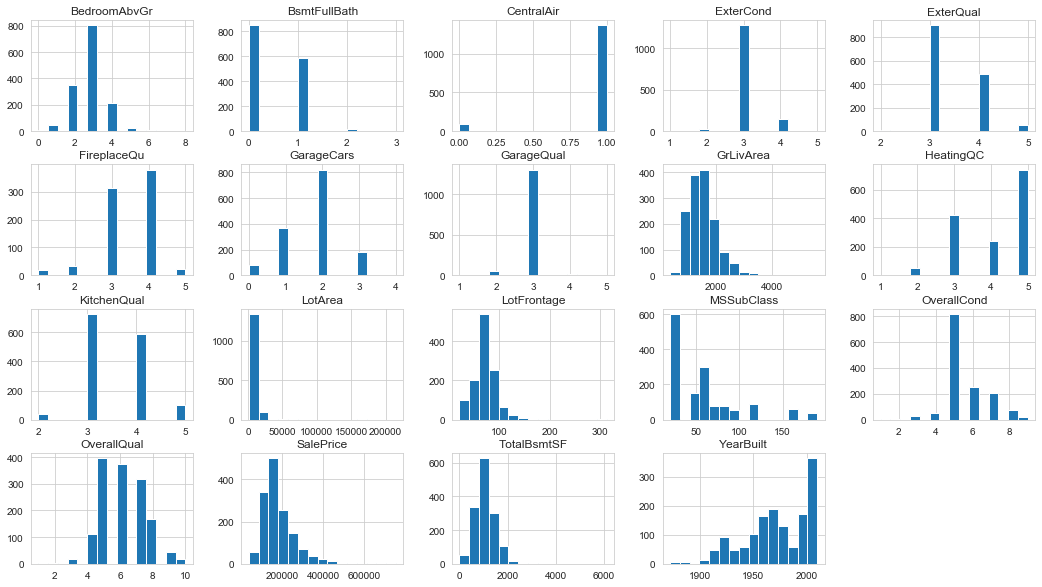

In [38]:
housing[interst_cols].hist(bins=15, figsize=(18, 10), layout=(4, 5));

## 2.5 Correlate Nummerical Columns

In [26]:
housing_num = housing[interst_cols].copy()

### 2.5.1 Pearson Coefficient

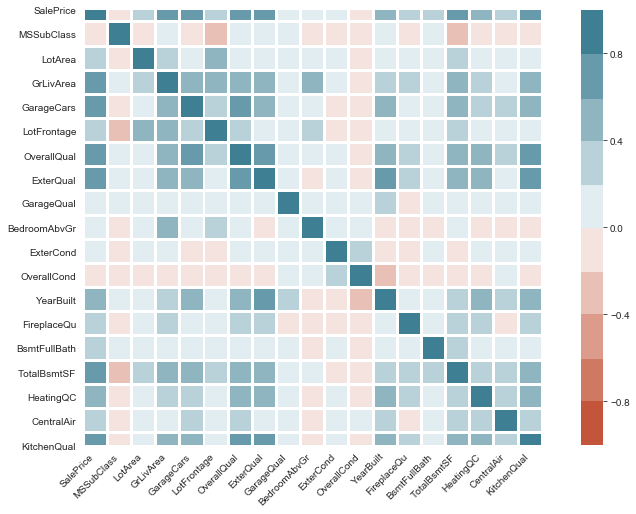

In [27]:
corr = housing_num.corr(method='pearson')

fig, ax = plt.subplots(figsize=(14,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=10),
    square=True,
    linewidths=2, 

)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


## 2.5.2 Spearman Coefficient

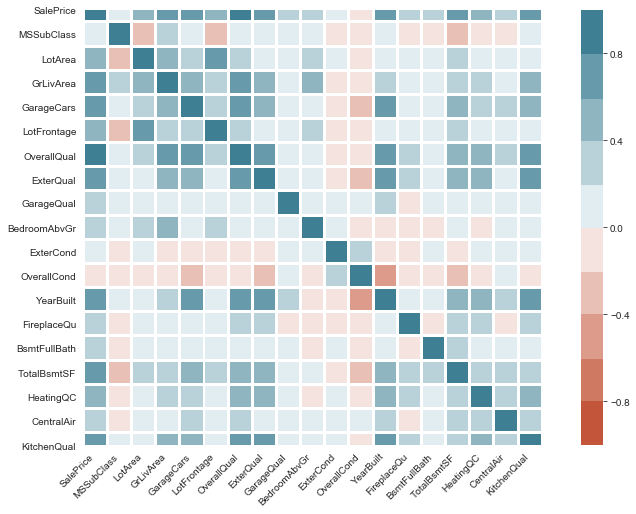

In [28]:
corr = housing_num.corr(method='spearman')

fig, ax = plt.subplots(figsize=(14,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=10),
    square=True,
    linewidths=2
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## 2.5.3 Get Columns with high Correlation coefficient

In [29]:
threshold_max = 0.3
threshhold_min = -1+threshold_max
housing_num_hight = pd.DataFrame()

for cols in interst_cols:
    for cols in housing_num:
        if threshhold_min <= np.corrcoef(housing_num[cols], housing_num["SalePrice"])[1,0] >= threshold_max:
            housing_num_hight[cols] = housing_num[cols]

In [30]:
print(f"the columns with an correlation coefficient +-{threshold_max} that can be selected are: {list(housing_num_hight.columns)}")

the columns with an correlation coefficient +-0.3 that can be selected are: ['SalePrice', 'GrLivArea', 'GarageCars', 'OverallQual', 'ExterQual', 'YearBuilt', 'TotalBsmtSF', 'HeatingQC', 'KitchenQual']


In [31]:
# OLS errored due to infs or nan. remove them
housing_num_hight = (housing_num_hight
                .replace([np.inf, -np.inf], np.nan))

### 2.5.4 Regression, using statsmodels.api

In [32]:
Y_1 = housing_num_hight[["SalePrice"]]

X_1 = housing_num_hight.loc[:, housing_num_hight.columns != 'SalePrice']
X_1 = sm.add_constant(X_1)

result = sm.OLS(Y_1, X_1).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     643.1
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:51:34   Log-Likelihood:                -17310.
No. Observations:                1450   AIC:                         3.464e+04
Df Residuals:                    1441   BIC:                         3.469e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.507e+05   8.64e+04     -5.213      

C:\Users\Andres\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Select Cols with p-val < 5%

In [33]:
housing_high_probable = []
for i in result.pvalues:
    if i < 0.05:
        housing_high_probable.append(i)

## 2.6 Categorical Columns

In [34]:
housing.Neighborhood.describe(include="category")

count      1450
unique       25
top       NAmes
freq        225
Name: Neighborhood, dtype: object

### 2.6.1 Transform Categorical into Dummy indicator

In [35]:
to_dummy

['MSZoning',
 'Utilities',
 'HouseStyle',
 'Heating',
 'Neighborhood',
 'Functional',
 'BsmtExposure']

**Neighborhood**

In [36]:
housing_neighborhood = pd.get_dummies(housing["Neighborhood"], prefix="Neighborhood").assign(SalePrice_sqm=housing.SalePrice_sqm)
housing_neighborhood.head()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SalePrice_sqm
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.674556
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,18.906250
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.866667
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.659686
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,17.531557


**get neighborhood with high valuable pricing**

In [44]:
threshold_max = 0.1
threshhold_min = -1+threshold_max
housing_neighborhood_r = pd.DataFrame()

for cols in interst_cols:
    for cols in housing_neighborhood:
        if threshhold_min <= np.corrcoef(housing_neighborhood[cols], housing_neighborhood["SalePrice_sqm"])[1,0] >= threshold_max:
            housing_neighborhood_r[cols] = housing_neighborhood[cols]

In [46]:
housing_neighborhood_r.head()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_MeadowV,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Somerst,Neighborhood_StoneBr,SalePrice_sqm
0,0,0,0,0,0,0,0,0,24.674556
1,0,0,0,0,0,0,0,0,18.906250
2,0,0,0,0,0,0,0,0,19.866667
3,0,0,0,0,0,0,0,0,14.659686
4,0,0,0,0,0,0,0,0,17.531557


In [52]:
list(housing_neighborhood_r.columns)

['Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_MeadowV',
 'Neighborhood_NPkVill',
 'Neighborhood_NridgHt',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'SalePrice_sqm']

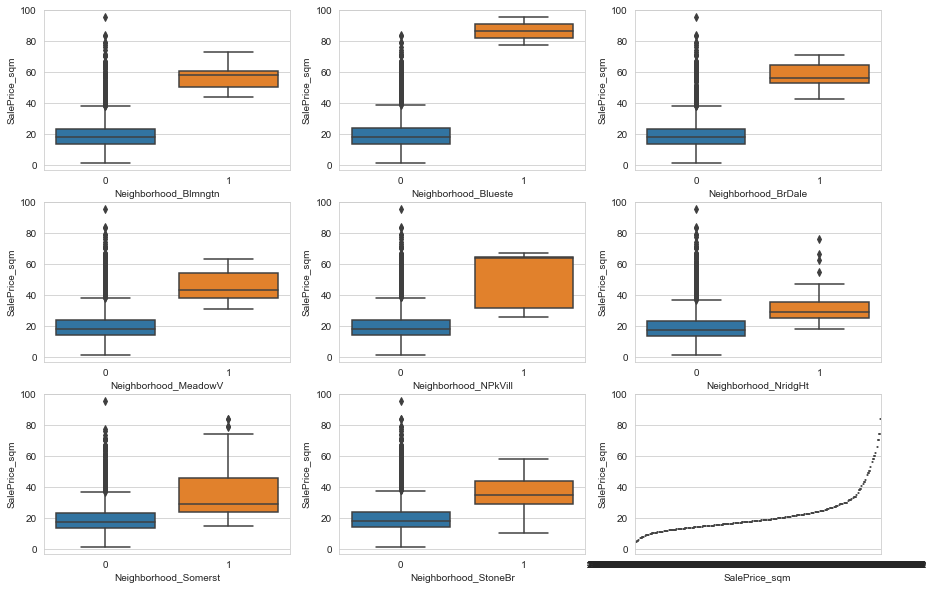

In [50]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for var, subplot in zip(housing_neighborhood_r, ax.flatten()):
    sns.boxplot(x=var, y='SalePrice_sqm', data=housing_neighborhood_r, ax=subplot)

In [47]:
Y_1 = housing_neighborhood_r[["SalePrice_sqm"]]

X_1 = housing_neighborhood_r.loc[:, housing_neighborhood_r.columns != 'SalePrice_sqm']
X_1 = sm.add_constant(X_1)

result = sm.OLS(Y_1, X_1).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          SalePrice_sqm   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     204.1
Date:                Mon, 18 Nov 2019   Prob (F-statistic):          8.73e-231
Time:                        19:58:58   Log-Likelihood:                -5156.0
No. Observations:                1450   AIC:                         1.033e+04
Df Residuals:                    1441   BIC:                         1.038e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   17.4883 

C:\Users\Andres\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Andres\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Andres\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Andres\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Andres\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .